# Notebook to Investigate LSTM Performance Variance by Huc Type - Assemble Metrics And Data

# Step 0 - Set up Notebook

In [25]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg
from snowML.datapipe import data_utils as du
from snowML.datapipe import get_dem as gd
from snowML.viz import vis_utils as vu

In [26]:
# initialize erathengine credentials
import ee
ee.Authenticate()

True

# Step1 - Get MLFlow Metrics

In [27]:
# function to retrieve metrics from ML server 
def load_ml_metrics(tracking_uri, run_id, save_local=False):
    mlflow.set_tracking_uri(tracking_uri)
    client = mlflow.MlflowClient()
    # Get all metric keys from the run
    run_data = client.get_run(run_id).data
    metric_keys = run_data.metrics.keys()
    # Retrieve full metric history for each key
    all_metrics = []
    for metric in metric_keys:
        history = client.get_metric_history(run_id, metric)
        for record in history:
            all_metrics.append({
                "Metric": metric,
                "Step": record.step,
                "Value": record.value
            })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    
    # Save to CSV if needed
    if save_local:
        f_out = f"run_id_data/metrics_from_{run_id}.csv"
        metrics_df.to_csv(f_out, index=False)

    return metrics_df

In [28]:
# function to extract only a specific metric
def extract_metric(df, metric_name):
    """Extracts rows where the Metric column ends with 'metric_name' and returns only Metric and Value columns."""
    return df[df['Metric'].str.endswith(metric_name)][['Metric', 'Value']].sort_values(by='Metric')

In [29]:
# function to extract data from a given epoch 
def summarize_by_step(df, step, agg_lev = 12):
    df_filtered = df[df["Step"] == step].copy()
    df_filtered["Metric_Type"] = df_filtered["Metric"].str.extract(r"(test_mse|test_kge|train_mse|train_kge)")
    df_filtered["HUC_ID"] = df_filtered["Metric"].str.extract(fr"(\d{{{agg_lev}}})")  

    # Take mean across HUC_ID if duplicates exist
    if df_filtered.duplicated(subset=["HUC_ID", "Metric_Type"]).any():
        df_filtered = df_filtered.groupby(["HUC_ID", "Metric_Type"], as_index=False)["Value"].mean()

    df_pivot = df_filtered.pivot(index="HUC_ID", columns="Metric_Type", values="Value")
    df_pivot.columns = ["Test KGE", "Test MSE", "Train KGE", "Train_MSE"]
    df_pivot_sorted = df_pivot.sort_index()
    df_selected = df_pivot_sorted[["Test MSE", "Test KGE"]]
    # print(df_selected)
    return df_selected

In [30]:
# function to summarize by epoch, all epochs
def summarize_by_step_all(df, agg_lev = 12):
    df_filtered = df.copy()
    df_filtered["Metric_Type"] = df_filtered["Metric"].str.extract(r"(test_mse|test_kge|train_mse|train_kge)")
    df_filtered["HUC_ID"] = df_filtered["Metric"].str.extract(fr"(\d{{{agg_lev}}})") 

    # Take mean across HUC_ID if duplicates exist
    if df_filtered.duplicated(subset=["HUC_ID", "Metric_Type", "Step"]).any():
        df_filtered = df_filtered.groupby(["HUC_ID", "Metric_Type", "Step"], as_index=False)["Value"].mean()

    df_filtered = df_filtered[df_filtered.columns.drop("Metric")]
    df_pivot = df_filtered.pivot(index=["Step", "HUC_ID"], columns="Metric_Type", values="Value").reset_index()
    df_pivot.columns = ["Step", "HUC_ID", "Test KGE", "Test MSE", "Train KGE", "Train_MSE"]
    return df_pivot

  

In [31]:
# 033984f1ce27482090740030fa25af9d  bald-ant, praire, 10 epoch
# ba300bba68fd451bbb684283fd3b3eab invinceable carp (hybrid loss), 30 epoch
# f76d3fe92f0a479da0e75b9141564287 capricous owl (single humidity), 30 epoch

run_id = "f76d3fe92f0a479da0e75b9141564287"
short_name = "Hum"
last_step = 29

#run_id = "ba300bba68fd451bbb684283fd3b3eab"
#short_name = "Mixed_Loss"
#last_step = 29

#run_id = "f64daf3d9751406ab4c054804c51c340"
#short_name = "Mixed_Loss_Orig10"
#last_step = 9


#run_id = "033984f1ce27482090740030fa25af9d"
#short_name = "Prairie"
#last_step = 9

#run_id = "4dde4b91d28349c9b88688a860a6cf34"
#short_name = "Prairie_Mixed_10"
#last_step = 9

#run_id = "6842189b35964aff8aa815cc517c5890"
#short_name = "Prairie_Hum_Mixed_30"
#last_step = 29



In [32]:
# upload from local 
f = f"../../mlflow_data/run_id_data/metrics_from_{run_id}.csv"
df_all_single = pd.read_csv(f)
print(df_all_single.shape)
df_all_single.head(2)

(58736, 3)


,Metric,Step,Value
0,test_kge_170200090209,0,0.820228
1,test_kge_170200090209,1,0.813941


In [33]:
df_last = summarize_by_step(df_all_single, last_step)

In [34]:
df_last.shape

(489, 2)

In [35]:
df_last.head(2)

,Test MSE,Test KGE
HUC_ID,,
170103020101,0.001919,0.901589
170103020102,0.001422,0.947771


In [36]:
df_all = summarize_by_step_all(df_all_single)
df_all.head(2)

,Step,HUC_ID,Test KGE,Test MSE,Train KGE,Train_MSE
0,0,170103020101,0.877088,0.001824,0.969960,0.000923
1,0,170103020102,0.952639,0.001429,0.931938,0.000770


# Step 2 - Plot histogram of test_kge for each epoch 

In [37]:
def plot_test_kge_histogram(df, output_file = "histogram.png"):
    """
    Plots a histogram of the test_kge values from a pandas DataFrame and saves it as 'histogram.png'.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the column 'test_kge'.
    """
    if 'Test KGE' not in df.columns:
        raise ValueError("DataFrame must contain a 'Test KGE' column")
    
    test_kge_values = df['Test KGE'].dropna()
    median_kge = np.median(test_kge_values)
    
    plt.figure(figsize=(8, 6))
    plt.hist(df['Test KGE'].dropna(), bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(median_kge, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_kge:.2f}')
    plt.text(median_kge, plt.ylim()[1] * 0.9, f'Median: {median_kge:.2f}', color='red', ha='right', fontsize=12, fontweight='bold')
    plt.xlabel('Test KGE')
    plt.ylabel('Frequency')
    plt.title('Histogram of Test KGE Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(output_file)
    plt.close()
    return plt


In [38]:
def stepwise_hists(metrics, epochs, f_out):

    temp_files = []

    for epoch in range(epochs): 
        metrics_epoch = summarize_by_step(metrics, epoch, agg_lev=12)  
        temp_file = f"hist_epoch_{epoch}.png"
        plot_test_kge_histogram(metrics_epoch, output_file=temp_file)
        temp_files.append((epoch, temp_file))
    
    # Determine grid size
    num_histograms = len(temp_files)
    cols = 3  # Three per row
    rows = (num_histograms + cols - 1) // cols  # Calculate needed rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))  # Adjust figure size
    axes = np.array(axes).reshape(rows, cols)  # Ensure axes is always 2D

    for ax in axes.flat:
        ax.axis("off")  # Hide all axes initially

    for (epoch, temp_file), ax in zip(temp_files, axes.flat):
        img = plt.imread(temp_file)  # Load the image
        ax.imshow(img)
        ax.set_title(f"Histograme of Test KGE Values for epoch {epoch}", fontsize=14, fontweight="bold")
        ax.axis("off")  # Hide axis labels

    plt.tight_layout()
    #f_out = f"kge_hist/{run_id}_all_hists.png"
    plt.savefig(f_out, dpi=300)
    plt.show()
    plt.close()

    # Cleanup temporary files
    for _, f in temp_files:
        os.remove(f)

    print(f"Saved combined histogram image as {f_out}")

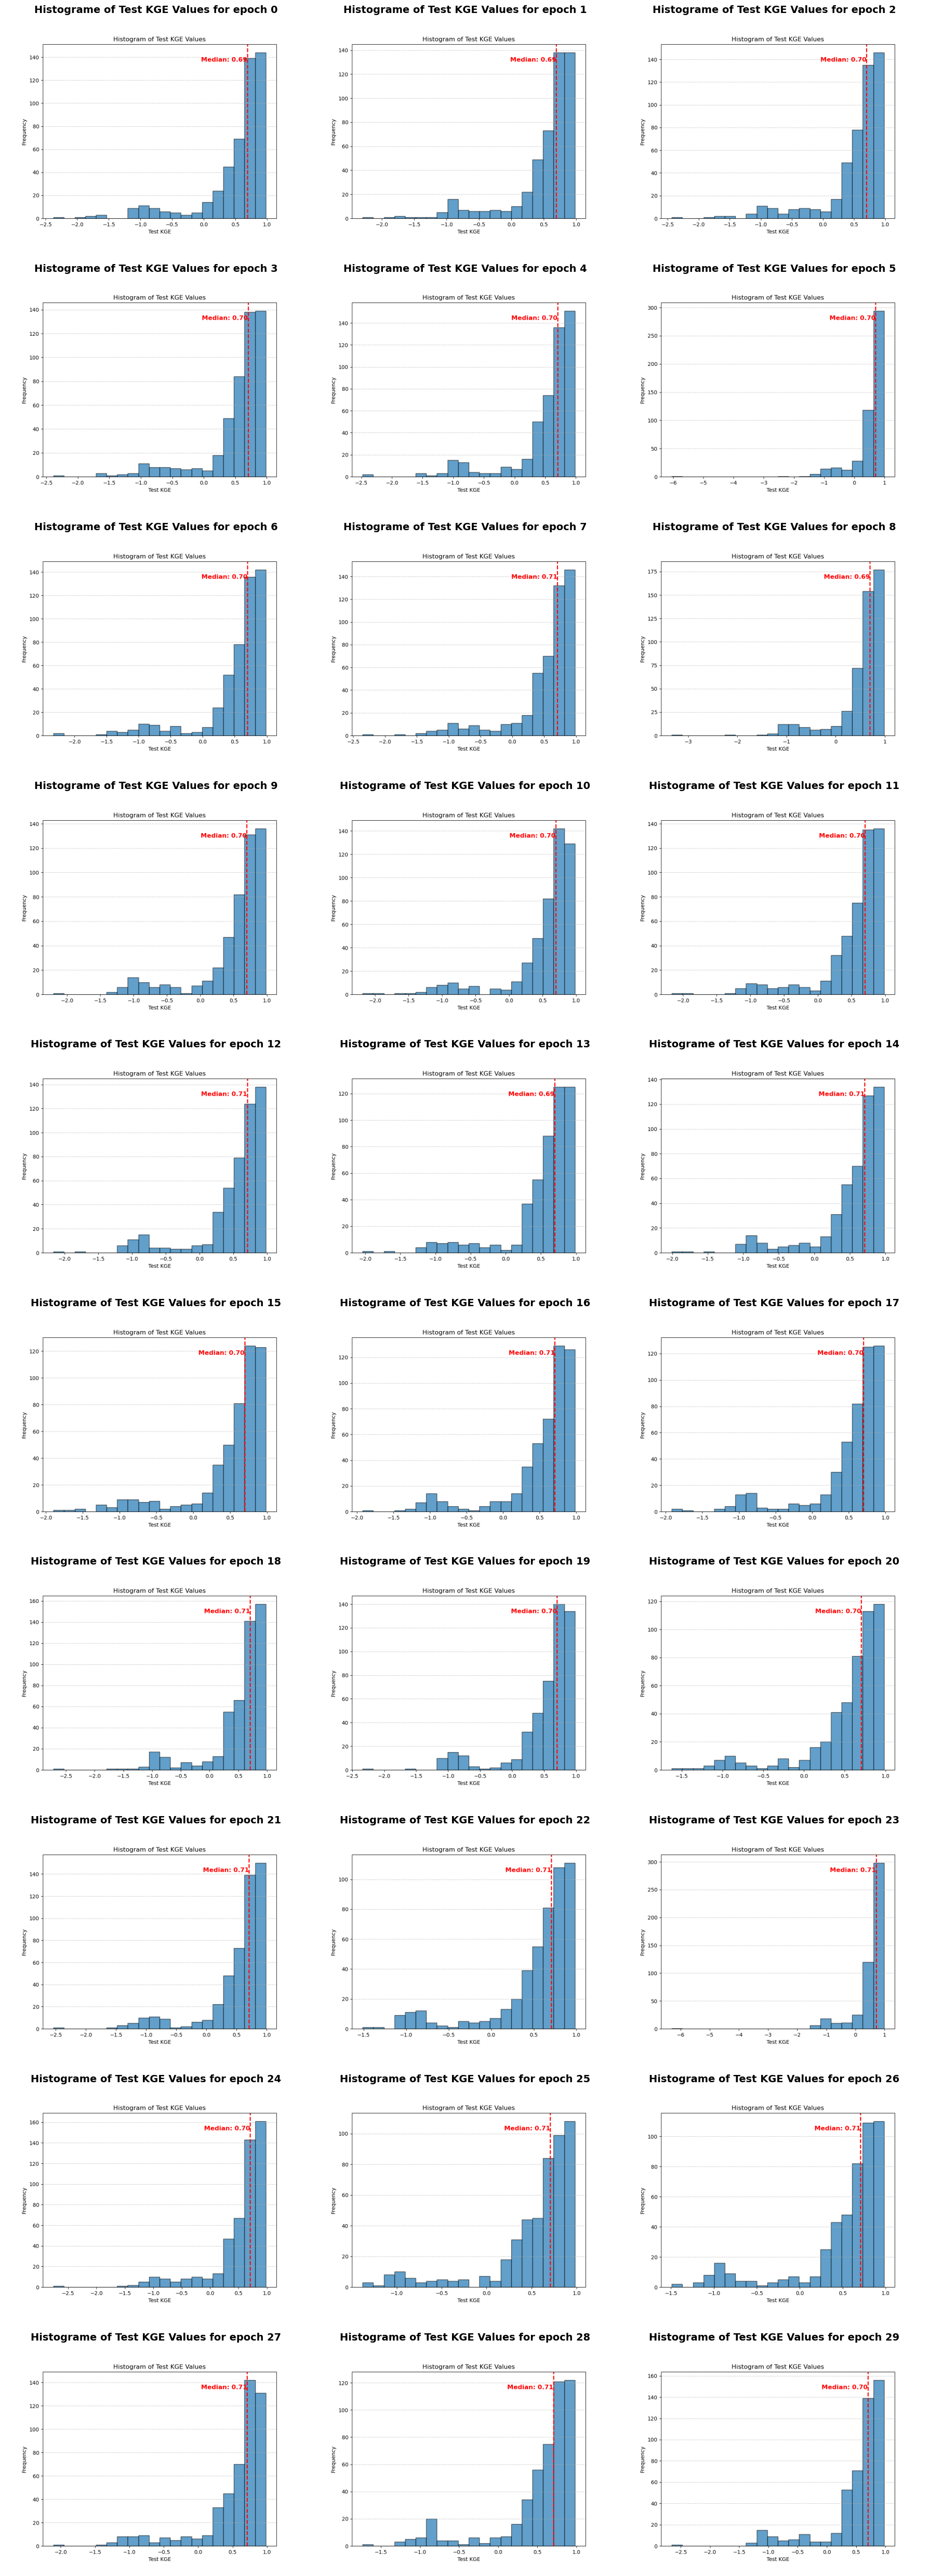

Saved combined histogram image as Stepwise_Histogram_All_Hucs_Singly_Trained_Hum


In [39]:
stepwise_hists(df_all_single, last_step+1, f"Stepwise_Histogram_All_Hucs_Singly_Trained_{short_name}")

# Step 2A - BoxPlots of KGE by Epoch

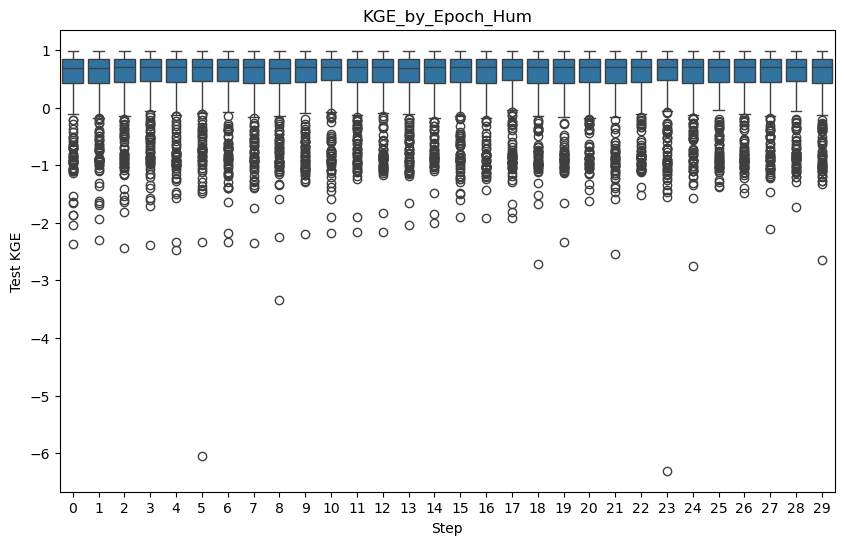

In [40]:
parameter = "Test KGE" 
title = f"KGE_by_Epoch_{short_name}"
groupby_column = "Step"

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x=groupby_column, y=parameter)
plt.title(title)
output_file = f"charts/{title}.png"
plt.savefig(output_file, bbox_inches='tight')

In [46]:
grouped_data = df_all.groupby(groupby_column)[parameter].agg(['count', 'median', 'mean', 'std'])
grouped_data.head(2)

,count,median,mean,std
Step,,,,
0,490,0.689700,0.506381,0.556568
1,490,0.691532,0.512450,0.539846


In [51]:
# Boxplots KGE By Epoch Maritime Only - Need to move this down
parameter = "Test KGE" 
title = f"KGE_by_Epoch_{short_name}_maritime"
groupby_column = "Step"
df_all_new = df_all.set_index("HUC_ID")
data_mar = df_all_new.merge(df_extra, left_index=True, right_index=True, how="left")
data_mar = data_mar[data_mar["Predominant_Snow"] == "Maritime"]
data_mar.head(2)




,Step,Test KGE,Test MSE,Train KGE,Train_MSE,Tundra,Boreal Forest,Maritime,Ephemeral,Prairie,Montane Forest,Ice,Ocean,Predominant_Snow
HUC_ID,,,,,,,,,,,,,,
170200090101,0,0.724232,0.057303,0.674235,0.073660,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,Maritime
170200090102,0,0.814436,0.051196,0.793673,0.059078,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,Maritime


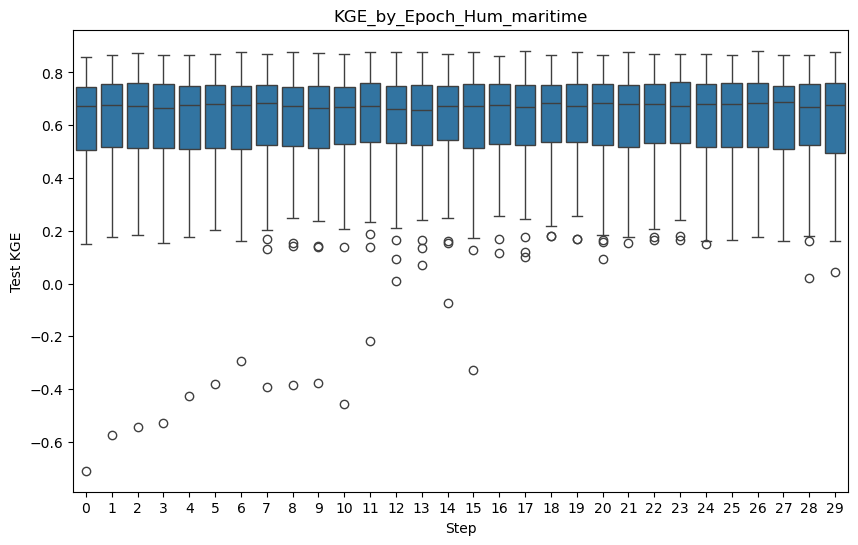

In [52]:

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_mar, x=groupby_column, y=parameter)
plt.title(title)
output_file = f"charts/{title}.png"
plt.savefig(output_file, bbox_inches='tight')

In [53]:
stepwise_hists(data_mar, last_step+1, f"Stepwise_Histogram_All_Hucs_Singly_Trained_{short_name}_maritime")

KeyError: 'Metric'

# Step 3 - Extract Last Epoch of Data 

In [18]:
# extract the last epoch of data 
df_all_last =  summarize_by_step(df_all_single, last_step, agg_lev = 12)
print(df_all_last.shape)
df_all_last.head(2)

(502, 2)


,Test MSE,Test KGE
HUC_ID,,
170103020101,0.002068,0.871154
170103020102,0.003653,0.810386


# Step 4 Add in Snow Class Data 

In [41]:
# get the snow class data 
HUC_LIST = [17010302, 17010304,
            17020009, 17020010, 17020011,
            17030001, 17030002, 17030003,
            17060207, 17060208, 
            17110005, 17110006, 17110007, 17110008, 17110009]

#HUC_LIST = [16040101, 16040102, 16040103, 16040106, 16040109]

HUC_LIST_OF_LISTS = [[huc, '12'] for huc in HUC_LIST]
df_dict = {} 
for input_pair in HUC_LIST_OF_LISTS: 
    #print(f"processing huc {input_pair[0]}")
    _, _, df_predom = st.process_all(input_pair[0], input_pair[1])
    df_dict[input_pair[0]] = df_predom


In [42]:
# combine the dfs
df_list = []
for huc_id, df in df_dict.items():
    df_list.append(df)
df_extra = pd.concat(df_list)
df_extra = df_extra.set_index("huc_id")
print(df_extra.shape)
df_extra.head(2)

(551, 9)


,Tundra,Boreal Forest,Maritime,Ephemeral,Prairie,Montane Forest,Ice,Ocean,Predominant_Snow
huc_id,,,,,,,,,
170103020101,0.0,0.0,0.0,0.0,11.0,89.0,0.0,0.0,Montane Forest
170103020102,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,Montane Forest


In [43]:
# Merge the additional data with df_all_ep10 based on the index (huc_id)
df_merged = df_all_last.merge(df_extra, left_index=True, right_index=True, how="left")

# select columns to display
col_to_kp = ["Test MSE", "Test KGE", "Ephemeral", "Predominant_Snow"]
df_merged = df_merged[col_to_kp]

# Display the updated worst10
print(df_merged.shape)
df_merged.head(2)

(502, 4)


,Test MSE,Test KGE,Ephemeral,Predominant_Snow
HUC_ID,,,,
170103020101,0.002068,0.871154,0.0,Montane Forest
170103020102,0.003653,0.810386,0.0,Montane Forest


In [22]:
# Define color mapping
color_map = {
    "Ephemeral": "#E6E6FA",
    "Maritime": "blue",
    "Montane Forest": "darkgreen",
    "Prairie": "lightgreen",
}

# Assign colors based on the Predominant_Snow column, defaulting to red if not in the map
df_merged["color_snow_type"] = df_merged["Predominant_Snow"].map(color_map).fillna("white")
df_merged.head(2)


,Test MSE,Test KGE,Ephemeral,Predominant_Snow,color_snow_type
HUC_ID,,,,,
170103020101,0.002068,0.871154,0.0,Montane Forest,darkgreen
170103020102,0.003653,0.810386,0.0,Montane Forest,darkgreen


In [23]:
# Step 5 Add in Basin Geometries & Mean elevation 

In [24]:
time_start = time.time()
df_merged2 = df_merged.copy()
num_hucs = len(df_merged2.index)
print(f"hucs to process is {num_hucs}")
i = 0 
for huc_id in df_merged2.index: 
    i+=1
    if i%10 == 0: 
        print(f"Done processing {i} hucs")
    geos = gg.get_geos_with_name(huc_id, '12')
    df_merged2.loc[df_merged2.index == huc_id, "Name"] = geos.iloc[0]["name"]
    df_merged2.loc[df_merged2.index == huc_id, "geometry"] = geos.iloc[0]["geometry"]
    dem_ds = gd.get_dem(geos)
    mean_elev = gd.calc_mean_dem(dem_ds)
    df_merged2.loc[df_merged2.index == huc_id, "mean_elevation"] = mean_elev
merged_gdf = gpd.GeoDataFrame(df_merged2, geometry="geometry")
merged_gdf.set_crs("EPSG:4326", inplace=True) 
du.elapsed(time_start)


# Note: This takes about 30 minutes!

hucs to process is 502
Done processing 10 hucs
Done processing 20 hucs
Done processing 30 hucs
Done processing 40 hucs
Done processing 50 hucs
Done processing 60 hucs
Done processing 70 hucs
Done processing 80 hucs
Done processing 90 hucs
Done processing 100 hucs
Done processing 110 hucs
Done processing 120 hucs
Done processing 130 hucs
Done processing 140 hucs
Done processing 150 hucs


KeyboardInterrupt: 

In [ ]:
merged_gdf.head(2)

In [ ]:
# Step 6 - Add a column to indicate which Huc08 the Huc_ID Belongs To 
merged_gdf['Huc_08'] = merged_gdf.index.astype(str).str[:8]
merged_gdf.head(2)

In [ ]:
# create a df of unique huc_08 values, and find the corresponding huc name 
df_huc_08 = merged_gdf[['Huc_08']].drop_duplicates().reset_index(drop=True)
for huc_id in df_huc_08["Huc_08"]:  
    geos = gg.get_geos_with_name(huc_id, '08')
    name = geos.iloc[0]["name"]
    df_huc_08.loc[df_huc_08["Huc_08"] == huc_id, "Huc_08_nm"] = name
df_huc_08.head(2)

In [ ]:
# Reset index of merged_gdf to make HUC_ID a regular column before merging
merged_gdf_reset = merged_gdf.reset_index()

# Merge using the Huc_08 column and preserve all values from merged_gdf
merged_gdf_with_huc_nm = merged_gdf_reset.merge(df_huc_08, on="Huc_08", how="left")

# Set the index back to the original HUC_ID after the merge
merged_gdf_with_huc_nm.set_index('HUC_ID', inplace=True)

# Show the first two rows
merged_gdf_with_huc_nm.head(2)


In [ ]:
col_to_kp = ["Name", "Test MSE", "Test KGE", "Predominant_Snow", "color_snow_type", "mean_elevation", "Huc_08", "Huc_08_nm", "geometry"]

In [ ]:
merged_gdf_slim = merged_gdf_with_huc_nm[col_to_kp]
merged_gdf_slim.head(2)

In [ ]:
merged_gdf_slim.explore(color=merged_gdf_slim['color_snow_type'], legend=True)

In [ ]:
snow_type_counts = merged_gdf_slim["Predominant_Snow"].value_counts()
print(snow_type_counts)


In [ ]:
# Step Last Save File 

In [ ]:
# save the combined data to a local_file
f = f"single_all_metrics_w_snow_types_and_elev_{short_name}.csv"
merged_gdf_slim.to_csv(f, index = True)

In [ ]:
print(f)